In [1]:
from dataclasses import dataclass

# image processing
import cv2
from matplotlib import pyplot

# audio
import numpy as numpy
from scipy.io import wavfile
from pydub import AudioSegment
from pydub.playback import play


In [2]:
sample_rate = 44100

In [3]:
@dataclass
class Blob:
    # Represents component/ labelled area in image
    x: int
    y: int
    width: int
    height: int
    area: int
    density: int
    center_x: int
    center_y: int

def process_image(image_file_name):
    image = cv2.imread(image_file_name)
    small = cv2.resize(image, (0,0), fx=0.1, fy=0.1) 
    blurred = cv2.GaussianBlur(small,(7,7),cv2.BORDER_DEFAULT)
    gray = cv2.cvtColor(blurred, cv2.COLOR_BGR2GRAY)
    threshold, black_and_white_image = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
    num_labels, labelled_image, label_stats, centroids = cv2.connectedComponentsWithStats(black_and_white_image, 2, cv2.CV_32S)
    
    blobs = []
    for l,c in zip(label_stats[1:], centroids[1:]):
        blob = Blob(x=l[cv2.CC_STAT_LEFT], 
                    y=l[cv2.CC_STAT_TOP], 
                    width=l[cv2.CC_STAT_WIDTH], 
                    height=l[cv2.CC_STAT_HEIGHT], 
                    area=l[cv2.CC_STAT_AREA],
                    density=int(l[cv2.CC_STAT_AREA]/l[cv2.CC_STAT_WIDTH]),
                    center_x=int(c[0]),
                    center_y=int(c[1]))
        blobs.append(blob)
    
    return image, labelled_image, blobs

# this function and tuned frequency values are from: https://towardsdatascience.com/music-in-python-2f054deb41f4
def get_sine_wave(frequency, duration, sample_rate=sample_rate, amplitude=4096):
    theta = numpy.linspace(0, duration, int(sample_rate*duration))
    wave = amplitude*numpy.sin(2*numpy.pi*frequency*theta)
    return wave

def normalise(value, min_input, max_input, min_output, max_output): 
    if value > max_input:
        value = max_input
    value = value if value <= max_input else max_input
    value = value if value >= min_input else min_input
    return ((value - min_input) / (max_input - min_input)) * (max_output - min_output) + min_output

def sine_wave_to_audio_segment(sine_wave):
    return AudioSegment(
        sine_wave.astype("float32").tobytes(), 
        frame_rate=sample_rate,
        sample_width=4, 
        channels=1
    )

In [4]:
def get_audio_segment(sounds, beats):
    combined = sine_wave_to_audio_segment(numpy.zeros(sample_rate*(beats))) # cuts off if dont add beat - why?
    for sound in sounds:
        sine_wave = get_sine_wave(sound.frequency, duration=sound.duration, amplitude=sound.amplitude)
        offset_sine_wave = numpy.concatenate([numpy.zeros(sound.offset),sine_wave])
        audio_segment = sine_wave_to_audio_segment(offset_sine_wave)
        if sound.volume < 1:
            audio_segment = audio_segment - 15
        combined = combined.overlay(audio_segment)
    return combined

In [5]:
def tune(frequency):
    tuned_frequencies = {
    "C2": 65.40639132514966,
    "C3": 130.8127826502993,
    "C4": 261.6255653005986,
    "D4": 293.6647679174076,
    "E4": 329.6275569128699,
    "F4": 349.2282314330039,
    "G4": 391.99543598174927,
    "A4": 440.0,
    "B4": 493.8833012561241,
    "C5": 523.2511306011972,
    }
    for f in tuned_frequencies.values():
        if frequency < f:
            return f

In [6]:
@dataclass
class Sound:
    # Represents an individual sound in a 4 beat bar
    frequency: int
    amplitude: int
    duration: int
    offset: int
    decreasing: bool
    volume: float

def get_sound(blob, beats):
    return Sound(
            frequency=tune(normalise((1000 - blob.area), 0, 1000, 150, 450)),
            amplitude=2048/2,
            duration=normalise(blob.width, 0, 200, 1, beats),
            offset=int(normalise(blob.x, 0, 250, 0, sample_rate*beats)),
            decreasing=blob.y < blob.center_y,
            volume=1 if blob.width < 500 else 0.5,
    )
    

In [7]:
def alter_speed(sound, speed):
    sound_with_altered_frame_rate = sound._spawn(sound.raw_data, overrides={
     "frame_rate": int(sound.frame_rate * speed)
    })
    sound_with_altered_frame_rate.set_frame_rate(sound.frame_rate)
    return sound_with_altered_frame_rate


In [8]:
beats = 2
photos = ["i1c.jpg", "i2c.jpg", "i3c.jpg"]
processed = []
for p in photos:
    image, labelled_image, blobs = process_image(p)
    sounds = [get_sound(b, beats) for b in blobs if b.width < 100]
    audio_segment = get_audio_segment(sounds, beats)
    processed.append([image, labelled_image, audio_segment, blobs, sounds])
v3 = processed[0][2] * 2 + processed[1][2] * 2 + processed[2][2] * 2
v3.export("v3.mp3", format="mp3")
v3

In [10]:
beats = 4
photos = ["i1c.jpg", "i2c.jpg", "i3c.jpg"]
processed = []
for p in photos:
    image, labelled_image, blobs = process_image(p)
    sounds = [get_sound(b, beats) for b in blobs if b.width < 100]
    audio_segment = get_audio_segment(sounds, beats)
    processed.append([image, labelled_image, audio_segment, blobs, sounds])
v4 = processed[0][2] * 2 + processed[1][2] * 2 + processed[2][2] * 2
v4 = alter_speed(v4, 2)
v4.export("v4.mp3", format="mp3")
v4

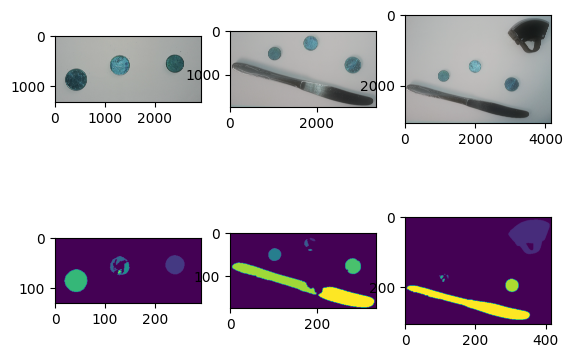

In [11]:
f, axarr = pyplot.subplots(2,3)

axarr[0,0].imshow(processed[0][0])
axarr[0,1].imshow(processed[1][0])
axarr[0,2].imshow(processed[2][0])

axarr[1,0].imshow(processed[0][1])
axarr[1,1].imshow(processed[1][1])
axarr[1,2].imshow(processed[2][1])